In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Collection and Cleaning
In this step, we gather the dataset and do some cleaning to make sure the images are ready for training without errors.

In [ ]:
# SPRINT 1: DATA COLLECTION, WRANGLING, AND CLEANING

In [ ]:
!pip install tensorflow

### Reproducibility Setup
We set random seeds so that results stay consistent every time we run the notebook.

In [ ]:
# Basic setup for reproducibility

import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Parameters
file_path = '/content/drive/MyDrive/' # Path where the dataset is stored
sampling_freq = 128              # EEG sampling frequency in Hz


### Loading the Data
Here we load the dataset into our program so that we can start preparing it for training the CNN.

In [ ]:
# Data Loading

def load_data(file_path):
    """
    Loads EEG data (X) and labels (y) from the DREAMERV dataset.
    Args:
        file_path (str): Path where DREAMERV_X.npy and DREAMERV_y.npy are stored.
    Returns:
        X (numpy.ndarray): EEG data of shape (samples, channels, time).
        y (numpy.ndarray): Labels array.
    """
    X = np.load(os.path.join(file_path, "DREAMERV_X.npy"), allow_pickle=True)
    y = np.load(os.path.join(file_path, "DREAMERV_y.npy"), allow_pickle=True)
    print(f"[INFO] Data loaded: X shape = {X.shape}, y shape = {y.shape}, unique labels = {np.unique(y)}")
    return X, y


### Checking and Cleaning Data
We quickly look at the dataset to spot any issues (like missing or broken images) and fix them if needed.

In [ ]:
# Data Inspection & Cleaning

def inspect_data(X, y):
    """Prints basic info about the dataset and checks for NaNs or Infs."""
    print("\nDataset Inspection")
    print(f"X shape: {X.shape} | y shape: {y.shape}")
    print(f"Unique labels: {np.unique(y)}")
    print(f"NaNs in X: {np.isnan(X).sum()}, NaNs in y: {np.isnan(y).sum()}")
    print(f"Infs in X: {np.isinf(X).sum()}, Infs in y: {np.isinf(y).sum()}")

    # Visualize label distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title("Label Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

### Normalizing Images
Normalization scales image pixel values to a smaller range, making training faster and more stable.

In [ ]:
# Normalization
def normalize_data(X):
    """
    Normalizes EEG data per sample per channel.
    """
    mean = np.mean(X, axis=2, keepdims=True)
    std = np.std(X, axis=2, keepdims=True)
    std[std == 0] = 1  # Avoid division by zero
    X_norm = (X - mean) / std
    print("[INFO] Normalization completed.")
    return X_norm


### Visualizing the Data
Plotting some images helps us confirm that the dataset looks correct and gives us an idea of what the model will learn from.


In [ ]:
# Visualizations

def visualize_signals(X, title="EEG Signal - Sample 0"):
    """Plots the first sample's first 2 channels."""
    plt.figure(figsize=(12, 4))
    for ch in range(2):
        plt.plot(X[0, ch], label=f'Channel {ch+1}')
    plt.title(title)
    plt.xlabel("Time Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

### Splitting Dataset
We divide the data into training and testing sets, so the model can learn on one part and be evaluated on the other.

In [ ]:
# Train-Test Split
def split_data(X, y, test_size=0.2):
    """
    Splits the dataset into train and test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    print(f"[INFO] Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
    print(f"Train label distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
    print(f"Test label distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")
    return X_train, X_test, y_train, y_test

### Building the Training Pipeline
This part connects all steps together — data loading, preprocessing, training, and evaluation of the CNN.

[INFO] Data loaded: X shape = (170246, 14, 256), y shape = (170246,), unique labels = [0 1]

Dataset Inspection
X shape: (170246, 14, 256) | y shape: (170246,)
Unique labels: [0 1]
NaNs in X: 0, NaNs in y: 0
Infs in X: 0, Infs in y: 0


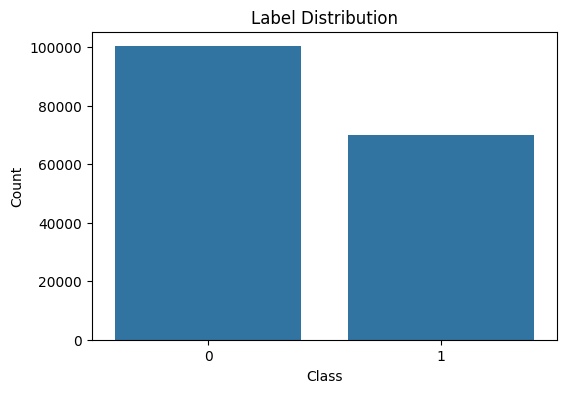

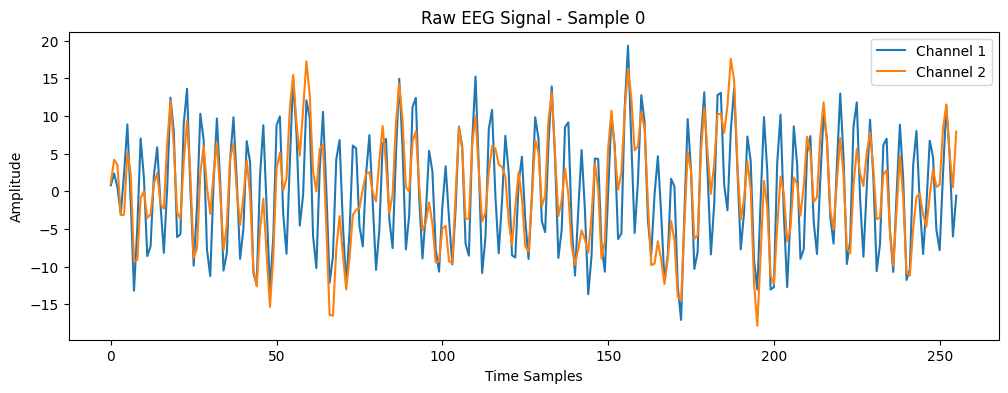

[INFO] Normalization completed.


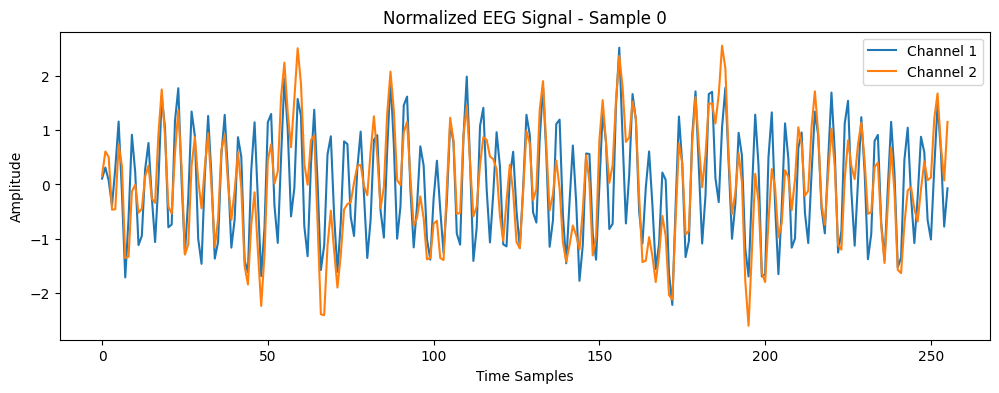

[INFO] Train samples: 136196, Test samples: 34050
Train label distribution: {np.int64(0): np.int64(80213), np.int64(1): np.int64(55983)}
Test label distribution: {np.int64(0): np.int64(20054), np.int64(1): np.int64(13996)}


In [ ]:
# Main pipeline
if __name__ == "__main__":
    # 1. Load
    X, y = load_data(file_path)

    # 2. Inspect
    inspect_data(X, y)
    visualize_signals(X, title="Raw EEG Signal - Sample 0")

    # 3. Clean & Normalize
    X_norm = normalize_data(X)
    visualize_signals(X_norm, title="Normalized EEG Signal - Sample 0")

    # 4. Split
    X_train, X_test, y_train, y_test = split_data(X_norm, y)

In [ ]:
# Sprint 2 Model Training and initial finetuning

In [ ]:
import torch, random, numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report

### Ensuring Reproducibility
Again, we set seeds here specifically for PyTorch so our experiments give consistent results.

In [ ]:
#  Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

### Creating a Dataset Class
A dataset class helps us load images and labels in the format PyTorch needs for training.

In [ ]:
#  Dataset Class
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

### Defining the CNN Model
Here we build our CNN architecture by stacking convolutional, pooling, and fully connected layers.

In [ ]:
# CNN Model
class EEG_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(14, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### Training Loop
We define how the model learns: forward pass, loss calculation, backward pass, and optimizer updates.

In [ ]:
# 4. Training

def train_model(model, train_loader, test_loader, epochs=50, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()
        acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")
    return model


### Evaluating the Model
This step checks how well the model performs on the test set after training.

In [ ]:
# Evaluation

def evaluate_model(model, test_loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch.cuda() if torch.cuda.is_available() else X_batch)
            preds.extend(outputs.argmax(1).cpu().numpy())
            labels.extend(y_batch.numpy())
    print(classification_report(labels, preds))

### Setting Up DataLoaders
DataLoaders help us batch and shuffle the dataset efficiently during training and testing.

In [ ]:
# CNN DataLoaders

train_loader_cnn = DataLoader(EEGDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader_cnn = DataLoader(EEGDataset(X_test, y_test), batch_size=32)


### Running Training and Evaluation
Now we bring it all together by training the CNN and then testing it on unseen data.

In [ ]:
# Train & Evaluate CNN

cnn_model = EEG_CNN()
cnn_model = train_model(cnn_model, train_loader_cnn, test_loader_cnn, epochs=50, lr=0.001)
evaluate_model(cnn_model, test_loader_cnn)

Epoch 1/50 | Loss: 2623.0459 | Accuracy: 0.6532
Epoch 2/50 | Loss: 2455.2174 | Accuracy: 0.6857
Epoch 3/50 | Loss: 2380.0443 | Accuracy: 0.6975
Epoch 4/50 | Loss: 2325.6368 | Accuracy: 0.7073
Epoch 5/50 | Loss: 2277.5476 | Accuracy: 0.7153
Epoch 6/50 | Loss: 2236.1934 | Accuracy: 0.7248
Epoch 7/50 | Loss: 2204.9806 | Accuracy: 0.7304
Epoch 8/50 | Loss: 2160.9465 | Accuracy: 0.7403
Epoch 9/50 | Loss: 2124.2965 | Accuracy: 0.7454
Epoch 10/50 | Loss: 2091.7092 | Accuracy: 0.7508
Epoch 11/50 | Loss: 2050.1465 | Accuracy: 0.7575
Epoch 12/50 | Loss: 2022.5627 | Accuracy: 0.7605
Epoch 13/50 | Loss: 1990.1021 | Accuracy: 0.7659
Epoch 14/50 | Loss: 1958.3352 | Accuracy: 0.7716
Epoch 15/50 | Loss: 1935.3526 | Accuracy: 0.7740
Epoch 16/50 | Loss: 1909.6946 | Accuracy: 0.7781
Epoch 17/50 | Loss: 1888.5090 | Accuracy: 0.7820
Epoch 18/50 | Loss: 1875.3402 | Accuracy: 0.7839
Epoch 19/50 | Loss: 1850.5048 | Accuracy: 0.7872
Epoch 20/50 | Loss: 1834.9447 | Accuracy: 0.7896
Epoch 21/50 | Loss: 1822.0897

### Saving the Model
We save the trained CNN so we don’t have to retrain it every time we want to use it.

In [ ]:
# Saving CNN Model
torch.save(cnn_model.state_dict(), "cnn_model.pth")

### Transfer Learning & Hyperparameter Tuning
We now try transfer learning with pretrained models and tune parameters to improve performance.

In [ ]:
# Reproducible Transfer Learning & Hyperparameter Tuning Pipeline

### Import for Transfer Learning
We re-import PyTorch here to set things up for transfer learning.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
import numpy as np
import random
import os
import copy

### Reproducibility for Transfer Learning
Same as before, we fix random seeds so results are stable for transfer learning experiments.

In [ ]:
# Reproducibility setup
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Worker Initialization
This function makes sure data loading workers also follow the same random seed settings.

In [ ]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)


### Dataset Class for Transfer Learning
We define another dataset class here, suited for working with pretrained CNNs.

In [ ]:
#  Dataset Class

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


### Loading a Pretrained CNN
Instead of training from scratch, we load a CNN that is already trained on a large dataset.

In [ ]:
#  Load pretrained CNN

cnn_model = EEG_CNN(num_classes=2)
cnn_model.load_state_dict(torch.load("cnn_model.pth"))


<All keys matched successfully>

### Freezing Layers
We freeze earlier layers so they don’t change, and only train the last part of the model.

In [ ]:
# Freeze convolutional layers
for param in cnn_model.conv1.parameters():
    param.requires_grad = False
for param in cnn_model.conv2.parameters():
    param.requires_grad = False


### Modifying Final Layer
Since our dataset has different classes, we replace the final layer to match our output classes.

In [ ]:
# Replace final fully connected layer for fine-tuning
num_classes = 2
cnn_model.fc2 = nn.Linear(32, num_classes)


### Hyperparameter Tuning
We define a grid of hyperparameters to try out, like learning rate and batch size, to find the best setup.

In [ ]:
# Hyperparameter grid

learning_rates = [0.001, 0.0005]
batch_sizes = [16, 32]

best_acc = 0
best_model = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training & Evaluating Transfer Model
We train the modified pretrained model and test its performance on our dataset.

In [ ]:
# Training & Evaluation

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\n[INFO] Training with lr={lr}, batch_size={batch_size}")

        train_loader = DataLoader(
            EEGDataset(X_train, y_train),
            batch_size=batch_size,
            shuffle=True,
            worker_init_fn=worker_init_fn
        )

        test_loader = DataLoader(
            EEGDataset(X_test, y_test),
            batch_size=batch_size,
            shuffle=False,
            worker_init_fn=worker_init_fn
        )

        model = copy.deepcopy(cnn_model).to(device)
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(10):  # few epochs for initial tuning
            model.train()
            total_loss, correct = 0, 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (outputs.argmax(1) == y_batch).sum().item()
            acc = correct / len(train_loader.dataset)
            print(f"Epoch {epoch+1}/10 | Loss: {total_loss:.4f} | Accuracy: {acc:.4f}")



[INFO] Training with lr=0.001, batch_size=16
Epoch 1/10 | Loss: 3592.9168 | Accuracy: 0.7996
Epoch 2/10 | Loss: 3247.5377 | Accuracy: 0.8193
Epoch 3/10 | Loss: 3208.6400 | Accuracy: 0.8222
Epoch 4/10 | Loss: 3187.8913 | Accuracy: 0.8234
Epoch 5/10 | Loss: 3167.4605 | Accuracy: 0.8250
Epoch 6/10 | Loss: 3158.7616 | Accuracy: 0.8253
Epoch 7/10 | Loss: 3146.5914 | Accuracy: 0.8257
Epoch 8/10 | Loss: 3139.9627 | Accuracy: 0.8263
Epoch 9/10 | Loss: 3131.2315 | Accuracy: 0.8266
Epoch 10/10 | Loss: 3123.2650 | Accuracy: 0.8277

[INFO] Training with lr=0.001, batch_size=32
Epoch 1/10 | Loss: 1847.2291 | Accuracy: 0.7938
Epoch 2/10 | Loss: 1661.1681 | Accuracy: 0.8142
Epoch 3/10 | Loss: 1636.8101 | Accuracy: 0.8184
Epoch 4/10 | Loss: 1626.4195 | Accuracy: 0.8189
Epoch 5/10 | Loss: 1617.3798 | Accuracy: 0.8206
Epoch 6/10 | Loss: 1609.3326 | Accuracy: 0.8214
Epoch 7/10 | Loss: 1602.0839 | Accuracy: 0.8211
Epoch 8/10 | Loss: 1594.2972 | Accuracy: 0.8227
Epoch 9/10 | Loss: 1589.4517 | Accuracy: 0.

### Final Evaluation
Lastly, we evaluate the final tuned model to check its accuracy and overall performance.

In [ ]:
# Evaluate
model.eval()
preds, labels = [], []
with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                preds.extend(outputs.argmax(1).cpu().numpy())
                labels.extend(y_batch.numpy())
print("[INFO] Test Classification Report:")
print(classification_report(labels, preds))

test_acc = sum(np.array(preds) == np.array(labels)) / len(labels)
if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
            best_hyperparams = {"lr": lr, "batch_size": batch_size}


[INFO] Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     20054
           1       0.79      0.74      0.77     13996

    accuracy                           0.81     34050
   macro avg       0.81      0.80      0.81     34050
weighted avg       0.81      0.81      0.81     34050



In [ ]:
# Save best model

print(f"\n[INFO] Best Hyperparameters: {best_hyperparams} | Test Accuracy: {best_acc:.4f}")
torch.save(best_model.state_dict(), "cnn_transfer_best.pth")


[INFO] Best Hyperparameters: {'lr': 0.0005, 'batch_size': 32} | Test Accuracy: 0.8137
